# Continuous Control

---

This is my 3rd project in the deep RL course offered by Udacity. [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
from ddpg_multiagent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Explore the env 

In [4]:
# reset the environment
env_itter = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_itter.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_itter.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# DDPG Agent & Model Architecture Explanation


#### DDPG Agent
DDPG is very similar to the DQN agent, but is well suited for continuous problem spaces. 

It consists of two neural networks that work together to solve a continuous learning problem. The actor network models the agent's actions (policy based approach), while the critic network uses the actor networks action to approximate the maximizer of Qvalues in the next state (value based approach).

This key adjustment makes it different from other actor-critic agents, and more similar to a DQN learning approach. 

DDPG utilizes a replay buffer, soft-update logic (similar to DQN), and incorporates a noise adjustment to predicted actions (from the actor network) to stabilize learning. 

This implementation of DDPG can train multiple agents at one time. The key to this approach is appending each agents state, action, reward, next_state, done tuple to the replay buffer (and sampling from the shared experience). All the same agents are trained off the same actor-critic networks. Instead of one learning adjustment per action step, the network makes 'n' adjustments. Taking more learning steps (from the shared replay buffer) allow for faster training.

### Network Architecture
I have two networks that compose my DDPG agent.

#### Actor
- consists of four fully connected layers
- relu activations in between each layer, and a tanh activation on the output
- the state inputs are put though a bachnorm layer before being fed into the netowrk
- there outputs of the first fully connected layer are put through a bachnorm layer as well
- the first layer has 400 nodes, and all the other layers contain 300

#### Critic
- consists of four fully connected layers
- each layer has a leaky relu activation 
- after the first fully connected layer, we concat the output with teh action predictions from the actor network
- this gets fed through the last 3 fully connected layers
- the first layer has 400 nodes, and all the other layers contain 300


### Hyperparameters
I chose to implement four learning steps as my 'n step' parameter. This allows for the agents to learn quickly, but provides enough stability keep the networks from over-adjusting/over-fitting early on in training (before they have had time to explore the full environment). 

The actor has a LR of 1e-4, and the critic has a LR of 3e-4. I do not decay the L2 weights on the ADAM optimizer for the actor and critic. 

I also include a scale factor (1/sqrt(episode #)) to the noise adjustment. This lets the model rely more on its predictions (from the actor network) as the training steps go forward. This enabled the current model architecture to solve the environment. 

In this experiment, I do not discount future rewards. 


# Lets train the DDPG Agent!

In [5]:
agent = Agent(state_size=state_size,
              action_size=action_size, random_seed=777,discount_rew=False)

Episode 25	Average Score: 0.00	Min Score: 0.00	Max Score: 0.00	Episode score: -0.00
Episode 50	Average Score: 0.00	Min Score: 0.00	Max Score: 0.00	Episode score: -0.00
Episode 75	Average Score: 0.00	Min Score: 0.00	Max Score: 0.00	Episode score: -0.00
Episode 100	Average Score: 0.00	Min Score: 0.00	Max Score: 0.09	Episode score: -0.00
Episode 125	Average Score: 0.00	Min Score: 0.00	Max Score: 0.09	Episode score: -0.00
Episode 150	Average Score: 0.00	Min Score: 0.00	Max Score: 0.09	Episode score: -0.00
Episode 175	Average Score: 0.00	Min Score: 0.00	Max Score: 0.09	Episode score: -0.00
Episode 200	Average Score: 0.00	Min Score: 0.00	Max Score: 0.10	Episode score: 0.050
Episode 225	Average Score: 0.02	Min Score: 0.00	Max Score: 0.10	Episode score: 0.050
Episode 250	Average Score: 0.04	Min Score: 0.00	Max Score: 0.19	Episode score: 0.150
Episode 275	Average Score: 0.07	Min Score: 0.00	Max Score: 0.40	Episode score: 0.05
Episode 300	Average Score: 0.09	Min Score: 0.00	Max Score: 0.40	Episo

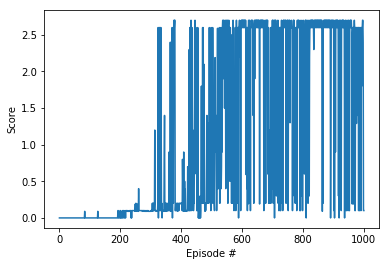

In [6]:
def ddpg(n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        #restart env 
        env_itter = env.reset(train_mode=True)[brain_name] #note training = True here
        #grab state of agents
        state =env_itter.vector_observations
        agent.reset()
        score = np.zeros(len(env_itter.agents)) 
        
        for t in range(max_t):
            #select an action for each agent based off learned weights
            #put a 1 instead of i_episodes if you do not want to decay the noise param
            action = agent.act(state,i_episode,add_noise=True)
            #send agents into env
            env_itter = env.step(action)[brain_name]  
            
            #pull out env results
            rewards = env_itter.rewards                      
            dones = env_itter.local_done
            next_states =env_itter.vector_observations
            #train agents
            agent.step(state, action, rewards, next_states, dones)
            score += rewards      
            state = next_states 
            #check if any agents finished
            if np.any(dones):
                break 
                
        #note we now only append the max score over both agents to the final score tally
        scores_deque.append(np.max(score))
        scores.append(np.max(score))

        print('\rEpisode {}\tAverage Score: {:.2f}\tMin Score: {:.2f}\tMax Score: {:.2f}\tEpisode score: {:.2f}'.format(i_episode, np.mean(scores_deque),np.min(scores_deque),np.max(scores_deque),np.mean(score)), end="")
        if i_episode % 25 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        
#         if np.mean(scores_deque) >= 0.5:
#             print('\nDone! Solved task in {} Episodes'.format(i_episode))
#             torch.save(agent.actor_local.state_dict(), 'solved_actor.pth')
#             torch.save(agent.critic_local.state_dict(), 'solved_critic.pth')
#             break
    
    return scores


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
#save out the score file
import pandas as pd
pd.DataFrame(scores).to_csv('results.csv')

## Nice, we solved the env in ~400 episodes!!

The learning looks farily stable with this model arch and weighted noise approach.

This version of DDPG makes 4 learning steps (4 samples from the replay buffer, and passes over the model). I thought this might yield an unstable agent; however, the agents are able to learn quickly and the performance does not degrade. In another test (over 2K episodes) the score slowly started to decrease after peaking at ~2.5 for a few hundred episodes. The number of agent steps should be experimented with to achieve optimal performance in the future. 


# Ideas for future work

Much like the other implementation of DDPG on the reacher environment, I think my model architecture can be optimized. Normalizing the input for the critic network should improve the agents stability, enhancing long term performance. 

I really want to implement a PPO agent and compare/contrast the performance with my DDPG version. I will start with a basic PPO agent, and then replicate the DOTA playing one. This should enhance my understanding of a few actor/critic algorithms for multiple agent RL problems!

These agents had very poor performance for the first 200 episodes. Experimenting with adding a prioritized replay buffer could help jump start the initial learning hurdles seen here. 

As I stated before, experimenting with the number of learning steps the network takes is a great next step. This will enhance my understanding of how much the agents learn off each sample of the replay buffer. 

I would also like to remove the noise scaler and allow the agents to experiment with their actions more. this might make it harder to learn initially, but they might benefit in the long run from exploring the state space for a longer period of time. 

Just as I stated in my last implementation of DDPG, it would be interesting to see if an RNN architecture could improve the results. Capturing temporal dependencies among past actions could improve the agents ability to discern optimal actions at the current time step. Combining the actor network with a Bidirectional LSTM encoder/decoder architecture will be my next experiment!



### Thank you Udacity for the course content and lesson structure that made this possible! I learned a ton from the RL work and am excited to continue exploration on my own